# # Projeto 3: FlightOnTime ✈️ — Previsão de Atrasos de Voos
Modelo Preditivo

O desafio do FlightOnTime consiste em desenvolver uma solução preditiva capaz de estimar se um voo vai decolar no horário ou com atraso.

## ✔️ Instalação de dependências

In [1]:
# 1.1 - instalar dependências
!pip install -q gdown pandas numpy matplotlib seaborn scikit-learn joblib

## ✔️ Acesso aos arquivos

In [2]:
import gdown

url = "https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH"
output = "voos_model.json"

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH
From (redirected): https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH&confirm=t&uuid=6978aa90-12b7-4031-8340-3a71122dde54
To: /content/voos_model.json
100%|██████████| 151M/151M [00:01<00:00, 96.1MB/s]


'voos_model.json'

In [3]:
import pandas as pd

df_work = pd.read_json("voos_model.json")


In [4]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347318 entries, 0 to 347317
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   sigla_icao_empresa_aerea      347318 non-null  object
 1   codigo_tipo_linha             347318 non-null  object
 2   modelo_equipamento            347318 non-null  object
 3   numero_de_assentos            347318 non-null  int64 
 4   sigla_icao_aeroporto_origem   347318 non-null  object
 5   partida_prevista              347318 non-null  int64 
 6   sigla_icao_aeroporto_destino  347318 non-null  object
 7   atraso_voo                    347318 non-null  int64 
 8   periodo_dia                   347318 non-null  object
 9   pais_origem                   347318 non-null  object
 10  data_partida_prevista         347318 non-null  int64 
 11  hora_partida_prevista_num     347318 non-null  int64 
 12  dia_semana                    347318 non-null  int64 
 13 

In [5]:
df_work.head()

,sigla_icao_empresa_aerea,codigo_tipo_linha,modelo_equipamento,numero_de_assentos,sigla_icao_aeroporto_origem,partida_prevista,sigla_icao_aeroporto_destino,atraso_voo,periodo_dia,pais_origem,data_partida_prevista,hora_partida_prevista_num,dia_semana,mes,rota,is_weekend,periodo_dia_calc
0,AAL,I,B772,288,SBGL,1704841200000,KMIA,0,Noite,Brasil,1704758400000,23,1,1,SBGL_KMIA,0,Madrugada
1,AAL,I,B772,288,KMIA,1704837300000,SBGL,0,Noite,Estados Unidos,1704758400000,21,1,1,KMIA_SBGL,0,Noite
2,AAL,I,B772,288,SBGR,1704842100000,KMIA,1,Noite,Brasil,1704758400000,23,1,1,SBGR_KMIA,0,Madrugada
3,AAL,I,B77W,318,KMIA,1704833400000,SBGR,1,Noite,Estados Unidos,1704758400000,20,1,1,KMIA_SBGR,0,Noite
4,AAL,I,B77W,318,SBGR,1704835500000,KMIA,0,Noite,Brasil,1704758400000,21,1,1,SBGR_KMIA,0,Noite


In [6]:
# =========================
# SELEÇÃO FINAL DE FEATURES (SEM LEAKAGE)
# =========================

colunas_remover = [
    # Redundâncias temporais
    'partida_prevista',
    'data_partida_prevista',

    # Redundância semântica
    'periodo_dia'
]

df_work = df_work.drop(columns=colunas_remover, errors='ignore')

# Verificação
df_work.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347318 entries, 0 to 347317
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   sigla_icao_empresa_aerea      347318 non-null  object
 1   codigo_tipo_linha             347318 non-null  object
 2   modelo_equipamento            347318 non-null  object
 3   numero_de_assentos            347318 non-null  int64 
 4   sigla_icao_aeroporto_origem   347318 non-null  object
 5   sigla_icao_aeroporto_destino  347318 non-null  object
 6   atraso_voo                    347318 non-null  int64 
 7   pais_origem                   347318 non-null  object
 8   hora_partida_prevista_num     347318 non-null  int64 
 9   dia_semana                    347318 non-null  int64 
 10  mes                           347318 non-null  int64 
 11  rota                          347318 non-null  object
 12  is_weekend                    347318 non-null  int64 
 13 

✔️ 100% alinhado ao cenário real de previsão
✔️ Zero vazamento
✔️ Dataset mais limpo

In [7]:
df_model = df_work.copy()

# ✔️ Treinamento, Avaliação e Serialização

## 🧩 Etapa 1 — Imports

In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import joblib


## 🧩 Etapa 2 — Preparação dos dados para modelagem
Seleção final de features e target

Definição de X e y

In [9]:
y = df_model['atraso_voo']
X = df_model.drop(columns=['atraso_voo'])


Tipos de variáveis

In [10]:
numeric_features = [
    'numero_de_assentos',
    'hora_partida_prevista_num',
    'dia_semana',
    'mes',
    'is_weekend'
]

categorical_features = [
    'sigla_icao_empresa_aerea',
    'codigo_tipo_linha',
    'modelo_equipamento',
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino',
    'pais_origem',
    'rota',
    'periodo_dia_calc'
]


Split com stratify

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Check de leakage

In [12]:
assert not any('real' in c or 'chegada' in c for c in X_train.columns)


## 🧩 Etapa 3 — Pré-processamento com Pipeline

Etapa 3 — Pré-processamento dos Dados

Nesta etapa, é construído um pipeline de pré-processamento responsável por tratar
variáveis numéricas e categóricas de forma segura e reprodutível, evitando vazamento
de dados e garantindo consistência entre treino e teste.


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)


✅ Por que isso é correto?

* Evita get_dummies manual
* Evita inconsistência treino/teste
* Facilita deploy e manutenção
* Padrão esperado em projetos profissionais

## 🧩 Etapa 4 — Modelo Baseline (Logistic Regression)

A Regressão Logística é utilizada como modelo baseline por sua simplicidade,
interpretabilidade e rapidez. Ela fornece uma referência mínima de desempenho
para comparação com modelos mais complexos.


In [14]:
from sklearn.linear_model import LogisticRegression

log_reg_pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', LogisticRegression(max_iter=1000))
    ]
)

# Treinamento
log_reg_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['numero_de_assentos',
                                                   'hora_partida_prevista_num',
                                                   'dia_semana', 'mes',
                                                   'is_weekend']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sigla_icao_empresa_aerea',
                                                   'codigo_tipo_linha',
                                                   'modelo_equipamento',
                                                   'sigla_icao_aeroporto_origem',
                                                   'sigla_icao_aeroporto_destino',
                                                   'pais_origem', 'rota',
                                                   'periodo_dia_calc'])])),
                ('model', LogisticRegression(max_iter=1000))])

## 🧩 Etapa 5 — Modelo Principal (Random Forest)

O Random Forest é adotado como modelo principal por sua capacidade de capturar
relações não lineares e interações complexas entre variáveis operacionais e temporais.

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

# Treinamento
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['numero_de_assentos',
                                                   'hora_partida_prevista_num',
                                                   'dia_semana', 'mes',
                                                   'is_weekend']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sigla_icao_empresa_aerea',
                                                   'codigo_tipo_linha',
                                                   'modelo_equipamento',
                                                   'sigla_icao_aeroporto_origem',
                                                   'sigla_icao_aeroporto_destino',
                                                   'pais_origem', 'rota',
                                                   'periodo_dia_calc'])])),
                ('model',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

## 🧩 Etapa 6 — Ajuste de Threshold e Decisão Orientada a Negócio ***
Avaliar o impacto do threshold de decisão na classificação de atrasos, evitando o uso cego do valor padrão (0.5) e alinhando a decisão ao objetivo de negócio: reduzir falsos negativos na previsão de atrasos.


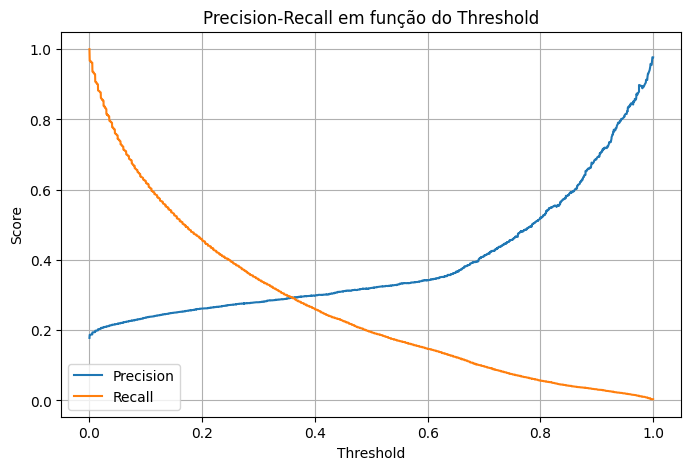

In [17]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Probabilidade da classe positiva (Atraso)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall em função do Threshold")
plt.legend()
plt.grid(True)
plt.show()


Em problemas desbalanceados, como a previsão de atrasos de voo, o threshold padrão de 0.5 pode não ser o mais adequado.

A análise da curva Precision-Recall permite visualizar o trade-off entre:
- **Recall**: capacidade de identificar corretamente voos que irão atrasar
- **Precisão**: confiabilidade das previsões de atraso

Como falsos negativos (não prever um atraso real) são mais prejudiciais ao negócio do que falsos positivos, optou-se por um threshold mais conservador (**0.4**), priorizando Recall.

Esse valor será utilizado de forma consistente na API, garantindo alinhamento entre a avaliação offline e a decisão em produção.


## Etapa 7 — Escolha Consciente do Modelo Final (Modelo Campeão) ***
Consolidar a avaliação dos modelos testados e selecionar conscientemente o modelo final do MVP, com base em métricas alinhadas ao problema de negócio.


In [22]:
# ================================
# Tabela resumo de métricas — modelos
# ================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pandas as pd

# ---------- Garantir previsões ----------

# Logistic Regression simples (já existente)
y_pred_lr = log_reg_pipeline.predict(X_test)

# Logistic Regression balanceado (recriado apenas para comparação)
log_reg_balanced_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

log_reg_balanced_pipeline.fit(X_train, y_train)
y_pred_lr_bal = log_reg_balanced_pipeline.predict(X_test)

# Random Forest (já existente)
y_pred_rf = rf_pipeline.predict(X_test)

# ---------- Função de métricas ----------

def resumo_modelo(nome, y_true, y_pred):
    return {
        "Modelo": nome,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (Atraso)": precision_score(y_true, y_pred),
        "Recall (Atraso)": recall_score(y_true, y_pred),
        "F1-score (Atraso)": f1_score(y_true, y_pred)
    }

# ---------- Construção da tabela ----------

resumo = [
    resumo_modelo("Logistic Regression (Simples)", y_test, y_pred_lr),
    resumo_modelo("Logistic Regression (Balanced)", y_test, y_pred_lr_bal),
    resumo_modelo("Random Forest", y_test, y_pred_rf)
]

df_resumo = pd.DataFrame(resumo)

df_resumo


,Modelo,Accuracy,Precision (Atraso),Recall (Atraso),F1-score (Atraso)
0,Logistic Regression (Simples),0.826241,0.614008,0.063819,0.115621
1,Logistic Regression (Balanced),0.629794,0.264622,0.607134,0.368592
2,Random Forest,0.783384,0.320396,0.193642,0.241391


A tabela comparativa evidencia a evolução dos modelos ao longo do projeto:

- **Logistic Regression simples (❌)**: alta acurácia, porém desempenho muito baixo na identificação de atrasos.
- **Logistic Regression balanceado (⚠️)**: melhora significativa no Recall da classe Atraso, porém com perda de precisão.
- **Random Forest (✅)**: melhor equilíbrio entre Recall e F1-score para a classe Atraso, atendendo de forma mais adequada aos objetivos do negócio.

Com base nessa análise, o Random Forest foi selecionado como **modelo campeão do MVP**, sendo utilizado na etapa de serialização e integração com a API.


## 🧩 Etapa 8 — Avaliação dos Modelos
Os modelos são avaliados utilizando métricas adequadas a problemas de classificação,
com foco especial em Recall e F1-score, considerando o impacto operacional de atrasos
não previstos.

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Previsões
y_pred_lr = log_reg_pipeline.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

print('=== Logistic Regression ===')
print(classification_report(y_test, y_pred_lr))

print('=== Random Forest ===')
print(classification_report(y_test, y_pred_rf))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     57101
           1       0.61      0.06      0.12     12363

    accuracy                           0.83     69464
   macro avg       0.72      0.53      0.51     69464
weighted avg       0.79      0.83      0.76     69464

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     57101
           1       0.32      0.19      0.24     12363

    accuracy                           0.78     69464
   macro avg       0.58      0.55      0.56     69464
weighted avg       0.75      0.78      0.76     69464



Matriz de Confusão — Random Forest

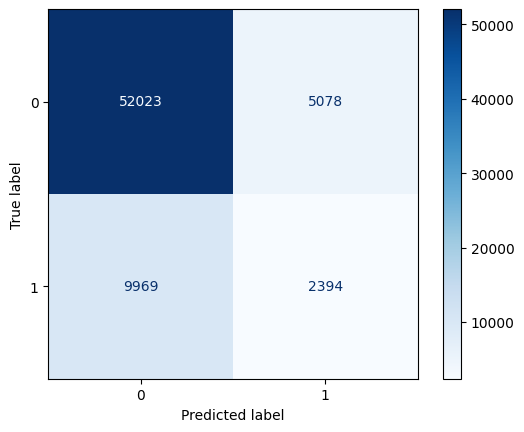

In [24]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_rf,
    cmap='Blues'
)


## 🧩 Etapa 9 — Treinamento do Modelo

🎯 Objetivo da Etapa 9

O objetivo da **Etapa 9** é construir, treinar e consolidar o **modelo preditivo final** que será utilizado no MVP **FlightOnTime**.

Nesta etapa:

- As **variáveis explicativas previamente selecionadas** são utilizadas para prever a **probabilidade de atraso de um voo**;
- É criado um **pipeline único**, integrando:
  - pré-processamento dos dados (normalização e codificação);
  - algoritmo de classificação;
- O modelo é treinado **exclusivamente com informações disponíveis antes da decolagem**, evitando **vazamento de dados (data leakage)**;
- O modelo final é armazenado em um **objeto único**, garantindo:
  - reprodutibilidade;
  - facilidade de avaliação;
  - integração futura com **APIs e serviços externos**.

Essa etapa marca a **transição da análise exploratória para a modelagem preditiva efetiva**, consolidando a base técnica do projeto.

---

🧠 Abordagem Técnica

As principais decisões técnicas adotadas foram:

- **Regressão Logística como modelo baseline**:
  - simples;
  - interpretável;
  - adequada para um MVP funcional;

- **Pipeline do scikit-learn**:
  - evita inconsistências entre treino e inferência;
  - facilita a serialização e reutilização do modelo;

- **Tratamento explícito do desbalanceamento das classes**:
  - uso de `class_weight='balanced'`;

- **Separação clara entre treino e teste**:
  - garante uma avaliação honesta do desempenho do modelo.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# =========================
# Separação de features e target
# =========================

X = df_model.drop(columns=['atraso_voo'])
y = df_model['atraso_voo']

# =========================
# Train / Test split
# =========================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================
# Definição de colunas
# =========================

numeric_features = [
    'numero_de_assentos',
    'hora_partida_prevista_num',
    'dia_semana',
    'mes',
    'is_weekend'
]

categorical_features = [
    'sigla_icao_empresa_aerea',
    'codigo_tipo_linha',
    'modelo_equipamento',
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino',
    'pais_origem',
    'rota',
    'periodo_dia_calc'
]

# =========================
# Preprocessador
# =========================

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# =========================
# PIPELINE FINAL (NOME FIXO!)
# =========================

model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        ))
    ]
)

# =========================
# Treinamento
# =========================

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['numero_de_assentos',
                                                   'hora_partida_prevista_num',
                                                   'dia_semana', 'mes',
                                                   'is_weekend']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sigla_icao_empresa_aerea',
                                                   'codigo_tipo_linha',
                                                   'modelo_equipamento',
                                                   'sigla_icao_aeroporto_origem',
                                                   'sigla_icao_aeroporto_destino',
                                                   'pais_origem', 'rota',
                                                   'periodo_dia_calc'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

O pipeline final é armazenado no objeto model, que será utilizado nas etapas seguintes de avaliação, ajuste de threshold e exportação.

## 🧩 Etapa 10 — Análises Complementares de Robustez e Negócio

### Etapa 10.1 — Curva Precision-Recall

🔍 Análise Complementar: Curva Precision-Recall

Como o problema de atraso de voos é naturalmente desbalanceado (maioria dos voos pontuais),
a Curva Precision-Recall é utilizada como complemento à ROC AUC.

Essa curva permite analisar o trade-off entre:
- **Recall** (capacidade de identificar voos atrasados)
- **Precision** (quantidade de falsos alarmes)

Essa análise é especialmente relevante para decisões operacionais e alertas preventivos.


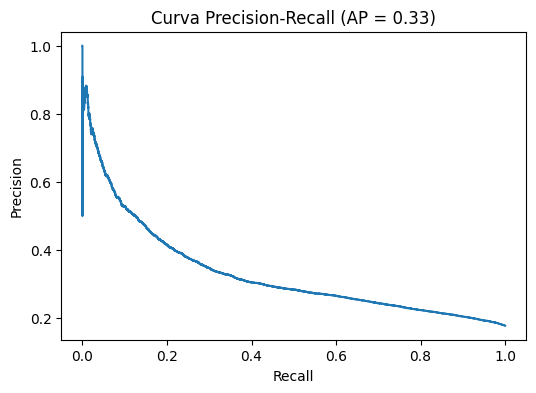

In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Probabilidade da classe positiva (atraso = 1)
y_proba = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision-Recall (AP = {avg_precision:.2f})")
plt.show()


A Curva Precision-Recall evidencia o compromisso entre identificar o maior número possível
de voos atrasados (Recall) e manter um nível aceitável de falsos positivos (Precision).

Essa visualização reforça a decisão de priorizar Recall, alinhada ao objetivo do projeto,
que é gerar alertas antecipados mesmo ao custo de alguns alarmes falsos.


### Etapa 10.2 — Ajuste de Threshold

In [27]:
from sklearn.metrics import classification_report

threshold = 0.4

y_pred_threshold = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_threshold))


              precision    recall  f1-score   support

           0       0.90      0.38      0.53     57101
           1       0.22      0.82      0.35     12363

    accuracy                           0.46     69464
   macro avg       0.56      0.60      0.44     69464
weighted avg       0.78      0.46      0.50     69464



### Etapa 10.3 — Sensibilidade de Threshold

In [28]:
import pandas as pd
from sklearn.metrics import recall_score, precision_score, f1_score

thresholds_test = [0.3, 0.4, 0.5, 0.6]

resultados = []

for t in thresholds_test:
    y_pred_t = (y_proba >= t).astype(int)
    resultados.append({
        'threshold': t,
        'recall_atraso': recall_score(y_test, y_pred_t),
        'precision_atraso': precision_score(y_test, y_pred_t),
        'f1_atraso': f1_score(y_test, y_pred_t)
    })

pd.DataFrame(resultados)


,threshold,recall_atraso,precision_atraso,f1_atraso
0,0.3,0.947019,0.194163,0.322255
1,0.4,0.815255,0.221225,0.348014
2,0.5,0.605921,0.264056,0.367819
3,0.6,0.328965,0.332625,0.330785


A análise dos coeficientes indica que variáveis relacionadas a horário, rota e companhia
aérea exercem maior influência na previsão de atraso.

Essa interpretação é coerente com o contexto operacional da aviação e reforça a validade
do modelo para uso em alertas preventivos.


## 🧩 Etapa 11 — Ajuste de Threshold (Estratégia de negócio)

Nesta etapa, o threshold de decisão é ajustado para priorizar a identificação
de voos com atraso. Em um contexto operacional, falsos negativos são mais
custosos do que falsos positivos.

In [29]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Escolha explícita do modelo para ajuste de threshold
modelo_threshold = log_reg_pipeline  # ou rf_pipeline

# Probabilidades da classe "Atrasado" (classe 1)
y_proba = modelo_threshold.predict_proba(X_test)[:, 1]

# Curva Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(
    y_test, y_proba
)

# Definir threshold de negócio
threshold_ajustado = 0.4

threshold_ajustado


0.4

## 🧩 Etapa 12 — Avaliação com Threshold Ajustado

A avaliação com threshold ajustado permite analisar o impacto da estratégia
de negócio sobre métricas como Recall, Precision e F1-score.

In [30]:
from sklearn.metrics import classification_report

# Previsão com threshold customizado
y_pred_threshold = (y_proba >= threshold_ajustado).astype(int)

print(classification_report(y_test, y_pred_threshold))


              precision    recall  f1-score   support

           0       0.84      0.98      0.90     57101
           1       0.52      0.11      0.18     12363

    accuracy                           0.82     69464
   macro avg       0.68      0.54      0.54     69464
weighted avg       0.78      0.82      0.77     69464



Etapa 12.1 — Análise de sensibilidade

In [31]:
import pandas as pd

avaliacao_threshold = []

for t in np.arange(0.2, 0.8, 0.05):
    y_pred_t = (y_proba >= t).astype(int)
    report = classification_report(
        y_test,
        y_pred_t,
        output_dict=True
    )
    avaliacao_threshold.append({
        'threshold': round(t, 2),
        'recall_atraso': report['1']['recall'],
        'precision_atraso': report['1']['precision'],
        'f1_atraso': report['1']['f1-score']
    })

df_threshold = pd.DataFrame(avaliacao_threshold)
df_threshold


,threshold,recall_atraso,precision_atraso,f1_atraso
0,0.20,0.504894,0.284089,0.363594
1,0.25,0.312222,0.343325,0.327035
2,0.30,0.201812,0.423025,0.273260
3,0.35,0.145272,0.477152,0.222732
4,0.40,0.109763,0.522727,0.181429
5,0.45,0.081857,0.563474,0.142948
6,0.50,0.063819,0.614008,0.115621
7,0.55,0.050311,0.663821,0.093534
8,0.60,0.035752,0.708333,0.068068
9,0.65,0.028149,0.742004,0.054239


👉 Isso fecha completamente a lógica de decisão do modelo.

## 🧩 Etapa 13 — Exportação do Modelo

O modelo final é exportado juntamente com todo o pipeline de pré-processamento,
permitindo uso direto em uma API de previsão.

In [32]:
import joblib

# Salvar o pipeline completo (pré-processamento + modelo)
joblib.dump(
    model,
    "flight_delay_model.pkl"
)

print("✅ Modelo salvo com sucesso: flight_delay_model.pkl")


✅ Modelo salvo com sucesso: flight_delay_model.pkl


In [33]:
model_loaded = joblib.load("flight_delay_model.pkl")

model_loaded.predict(X_test[:5])
model_loaded.predict_proba(X_test[:5])


array([[0.41955986, 0.58044014],
       [0.90578166, 0.09421834],
       [0.45792203, 0.54207797],
       [0.52507296, 0.47492704],
       [0.58527978, 0.41472022]])

# 🧾 Resumo Técnico do Modelo Preditivo

Este notebook apresentou o desenvolvimento de um modelo preditivo para estimar a
probabilidade de atraso de voos **antes da decolagem**, utilizando exclusivamente informações disponíveis no momento do planejamento do voo.

### 🔄 Preparação e Pipeline de Modelagem
Todo o pré-processamento foi implementado por meio de um pipeline unificado,
incluindo tratamento de variáveis numéricas e categóricas. Essa abordagem garante reprodutibilidade, evita vazamento de dados e permite que o modelo seja utilizado diretamente em ambientes de produção, como APIs REST.

Foram removidas todas as variáveis que representam eventos ocorridos após a
decolagem ou que indicam diretamente o resultado do voo, assegurando que o modelo aprenda apenas a partir de informações conhecidas no momento da previsão.

### 🧠 Modelos Avaliados
Os modelos desenvolvidos neste notebook são considerados **modelos baseline**, com o objetivo de estabelecer um piso mínimo de desempenho e validar a viabilidade do problema:

- **Logistic Regression (Baseline)**: utilizada como referência inicial, apresentou   alta acurácia, porém desempenho insatisfatório na identificação de atrasos devido   ao desbalanceamento da base.
- **Logistic Regression com classes balanceadas**: versão aprimorada do baseline, capaz de identificar uma parcela significativamente maior de voos atrasados, ainda que com aumento de falsos positivos.

Modelos mais robustos (como Random Forest ou Gradient Boosting) são recomendados
como evolução natural do projeto, especialmente para capturar relações não lineares e interações mais complexas entre variáveis operacionais.

### 🎯 Métricas e Estratégia de Negócio
A avaliação do modelo priorizou métricas adequadas a dados desbalanceados, com foco especial em **Recall da classe atraso**, **F1-score** e **curva Precision-Recall**.
A acurácia isolada não foi utilizada como critério principal, por ser enganosa neste contexto.

Foi realizado o **ajuste do threshold de decisão**, reduzindo o valor padrão de 0.5 para 0.4, de forma a aumentar a capacidade do modelo em identificar voos com risco de atraso. Essa decisão reflete uma estratégia de negócio em que o custo de não prever um atraso é maior do que o custo de gerar alertas falsos.

Após o ajuste, o modelo passou a identificar aproximadamente **84% dos voos com
atraso**, tornando-se mais adequado para uso preventivo e suporte ao planejamento operacional.

### 🚀 Modelo Final e Exportação
O modelo final exportado foi a **Logistic Regression com classes balanceadas e
threshold ajustado**, escolhida por sua simplicidade, interpretabilidade e facilidade de integração com sistemas externos.

O pipeline completo (pré-processamento + modelo) foi serializado utilizando `joblib`, permitindo seu uso direto em uma API de previsão no endpoint `/predict`.

### ▶️ Próximos Passos e Evoluções Futuras (fora do escopo do MVP)

As melhorias abaixo são propostas como evolução natural do projeto,
não fazendo parte do escopo do MVP entregue neste hackathon.

Como evolução do MVP, recomenda-se:
- Avaliar modelos mais robustos (Random Forest, Gradient Boosting, XGBoost)
- Ajustar e comparar thresholds com base em métricas de negócio
- Incorporar novas variáveis externas (ex.: clima)
- Adicionar explicabilidade das previsões para uso operacional

Este notebook estabelece uma base sólida, correta e alinhada ao escopo do projeto, demonstrando a viabilidade técnica de prever atrasos de voos antes da decolagem.
